In [1]:
# prep

library(tidyverse)
ess18 <- read_csv("https://github.com/CALDISS-AAU/workshop_R-intro/raw/master/data/ESS2018DK_subset.csv")

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.6     v dplyr   1.0.7
v tidyr   1.1.4     v stringr 1.4.0
v readr   2.0.2     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Rows: 1572 Columns: 16

-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr  (6): vote, prtvtddk, lvpntyr, tygrtr, gndr, edlvddk
dbl (10): idno, netustm, ppltrst, yrbrn, eduyrs, wkhct, wkhtot, grspnum, frl...


i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.



# Simple hypothesis testing in R

## Base stats functions

R has a wide range of statistical functions built in (part of base package `stats`).

### Correlation coefficients

Correlation coefficients between two columns can be calculated with `cor()`.

`cor()` contains the arguement "use" specifying what observations to use. By default it will include all observations - including missing. The option "complete.obs" specifies to only calculate for complete observations.

In [16]:
cor(ess18$eduyrs, ess18$netustm, use = "complete.obs")

[1] 0.05662359

Can also be done as a correlation test with `cor.test()`:

In [31]:
cor.test(ess18$eduyrs, ess18$netustm, use = "complete.obs")


	Pearson's product-moment correlation

data:  ess18$eduyrs and ess18$netustm
t = 2.1091, df = 1383, p-value = 0.03511
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.003961935 0.108972044
sample estimates:
       cor 
0.05662359 


### (Student's) t-test

`t.test()` performs both paired and unpaiared t-tests (left-tail, right-tail, two-tail). 

The main arguements are the two columns to be compared (x and y). If only x is specified, it will test whether the mean of the columns is different from zero.

"alternative" specifies the alternative hypothesis. It defaults to a two-sided t-test (`"two-sided"`). Other options are `"less"` for left-tail and `"greater"` for right-tail.

"paired" specifies whether it is a one sample or two sample t-test. It defaults to `FALSE` (unpaired).

Below is a right-tail t-test testing whether people work more than they are contracted to work (paired):

In [37]:
t.test(ess18$wkhtot, ess18$wkhct, alternative = "greater", paired = TRUE)


	Paired t-test

data:  ess18$wkhtot and ess18$wkhct
t = 14.953, df = 1440, p-value < 2.2e-16
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 2.449922      Inf
sample estimates:
mean of the differences 
               2.752949 


#### T-test between two groups

As an alternative to specifying two columns to compare, you can specify the hypothesis test as a formula.

Specifying hypothesis via formulas is a general feature in R and is used for various statistical modelling. 

Formulas in `t.test()` are specified as: `left-side ~ right-side`. To test differences in means between groups, right-side should be a factor with two levels indicating the groups.

In the standard `t.test()` function, the formula is specified first and then the data. The test belows tests differences in mean work hours between genders:

In [42]:
t.test(wkhtot ~ gndr, ess18)


	Welch Two Sample t-test

data:  wkhtot by gndr
t = -7.2195, df = 1499.2, p-value = 8.26e-13
alternative hypothesis: true difference in means between group Female and group Male is not equal to 0
95 percent confidence interval:
 -6.095408 -3.490832
sample estimates:
mean in group Female   mean in group Male 
            33.56140             38.35452 


### Calculating a t-test by hand

One benefit of using R (in terms of teaching) is that one can demonstrate how a t-test is calculated manually directly in R:

In [39]:
wkh_difs <- na.omit(ess18$wkhtot - ess18$wkhct)
wkh_meandif <- mean(wkh_difs)
sd_wkhdif <- sd(wkh_difs)
n_obs <- length(wkh_difs)

t_stat <- wkh_meandif / (sd_wkhdif/sqrt(n_obs))

t_stat

[1] 14.9528

In [40]:
p_value <- pt(t_stat, df = (n_obs-1), lower.tail = FALSE)
p_value

[1] 2.108203e-47

### Chi-square test

R also has a built-in chi-squared test of independence (`chisq.test`). This works either on table objects (using only the x argument) or by specifying the two vectors to test (specifying them as the x and y argument respectively):

In [4]:
# Chi-sqared test on table

gndr_vote_table <- table(ess18$gndr, ess18$vote)
chisq.test(gndr_vote_table)


	Pearson's Chi-squared test

data:  gndr_vote_table
X-squared = 4.2257, df = 2, p-value = 0.1209


In [5]:
# Chi-squared test on two vectors

chisq.test(ess18$gndr, ess18$vote)


	Pearson's Chi-squared test

data:  ess18$gndr and ess18$vote
X-squared = 4.2257, df = 2, p-value = 0.1209


## Hypothesis testing with `infer` (from `tidymodels`)

A downside of the built-in functions is that they do not have a common syntax: The way we set up the test varies depending on the test function. 

The "infer" package (part of tidymodels) offers a common syntax for hypothesis testing in R: https://infer.netlify.app/reference/index.html

**Features include**
- Common syntax for specifying hypothesis
- Simulation-based hypothesis testing
- Easy to use functions for confidence intervals, t-tests- chisquared-test etc.
- Results are always returned as a data frame (tibble)

In the example below, the two-sample t-test from before (comparing working hours between genders) is calculated using `infer`; here as a right-tail t-test:

In [60]:
library(infer)

ess18 %>%
    t_test(wkhtot ~ gndr, alternative = "less")

Warning message:
"The statistic is based on a difference or ratio; by default, for difference-based statistics, the explanatory variable is subtracted in the order "Female" - "Male", or divided in the order "Female" / "Male" for ratio-based statistics. To specify this order yourself, supply `order = c("Female", "Male")`."


statistic,t_df,p_value,alternative,estimate,lower_ci,upper_ci
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
-7.219549,1499.21,4.130186e-13,less,-4.79312,-Inf,-3.700412


### Simulation-based hypothesis testing

Below the test statistic is visualized alongside simulated null-hypothesis data based on the actual data:

Warning message:
"Removed 70 rows containing missing values."
Warning message:
"The statistic is based on a difference or ratio; by default, for difference-based statistics, the explanatory variable is subtracted in the order "Female" - "Male", or divided in the order "Female" / "Male" for ratio-based statistics. To specify this order yourself, supply `order = c("Female", "Male")` to the calculate() function."
Warning message:
"Removed 70 rows containing missing values."
Warning message:
"The statistic is based on a difference or ratio; by default, for difference-based statistics, the explanatory variable is subtracted in the order "Female" - "Male", or divided in the order "Female" / "Male" for ratio-based statistics. To specify this order yourself, supply `order = c("Female", "Male")` to the calculate() function."
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



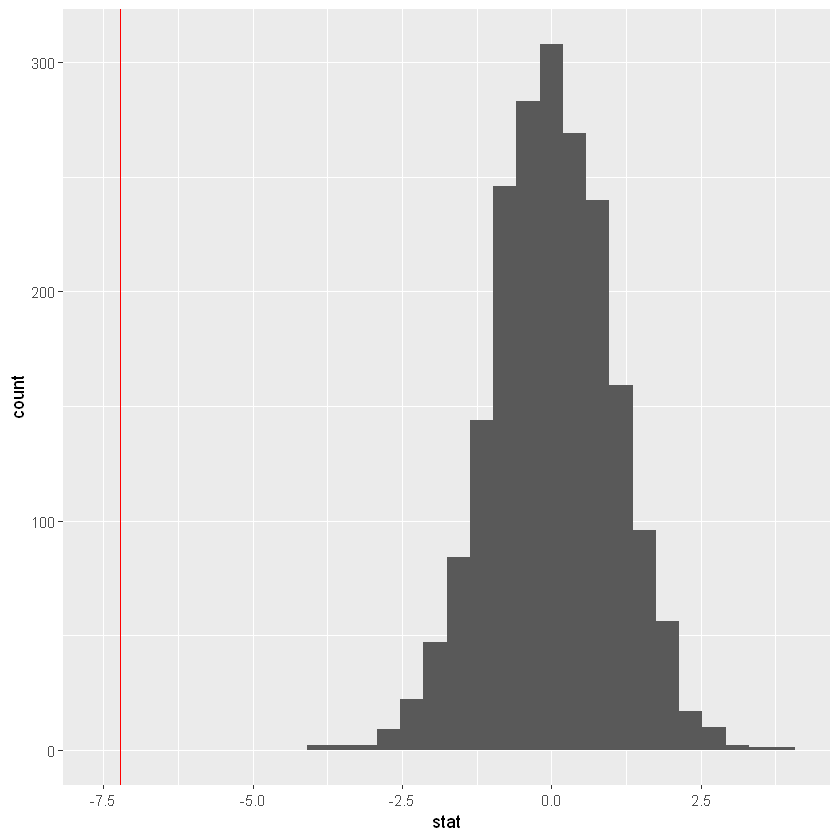

In [63]:
library(ggplot2)

# simulate null distribution
null_distn <- ess18 %>% 
  specify(wkhtot ~ gndr) %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 2000, type = "permute") %>% 
  calculate(
    stat = "t"
    )

# calculate observed statistic
obs_stat <- ess18 %>% 
  specify(wkhtot ~ gndr) %>% 
  calculate(
    stat = "t"
    ) %>%
    pull(stat)

# visualize
ggplot(null_distn, aes(x = stat)) + 
    geom_histogram() + 
    geom_vline(xintercept = obs_stat, colour = "red")

### Chi-squared with infer

In [65]:
ess18 %>%
    chisq_test(vote ~ gndr)

statistic,chisq_df,p_value
<dbl>,<int>,<dbl>
4.225705,2,0.1208926
